### Setup

In [27]:
from typing import List
from openai import OpenAI
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt

with open("qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

### Vertex Conversation and Search

#### Setup

In [28]:
from google.api_core.client_options import ClientOptions
from google.cloud import discoveryengine_v1 as discoveryengine

project_id='bq-test-data'
location='global'
data_store_id='pg-essays_1707496954734'

def get_vertex_response(benchMarkItem: BenchmarkItem) -> List[discoveryengine.SearchResponse]:
    
    client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )

    client = discoveryengine.SearchServiceClient(client_options=client_options)

    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=data_store_id,
        serving_config="default_config",
    )

    content_search_spec = discoveryengine.SearchRequest.ContentSearchSpec(
        snippet_spec=discoveryengine.SearchRequest.ContentSearchSpec.SnippetSpec(
            return_snippet=True
        ),
        summary_spec=discoveryengine.SearchRequest.ContentSearchSpec.SummarySpec(
            summary_result_count=5,
            include_citations=True,
            ignore_adversarial_query=True,
            ignore_non_summary_seeking_query=True,
        ),
    )
    
    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=benchMarkItem.question,
        page_size=10,
        content_search_spec=content_search_spec,
        query_expansion_spec=discoveryengine.SearchRequest.QueryExpansionSpec(
            condition=discoveryengine.SearchRequest.QueryExpansionSpec.Condition.AUTO,
        ),
        spell_correction_spec=discoveryengine.SearchRequest.SpellCorrectionSpec(
            mode=discoveryengine.SearchRequest.SpellCorrectionSpec.Mode.AUTO
        ),
    )

    response = client.search(request)
    return response.summary.summary_text

#### Testing

In [29]:
benchmark_item = BenchmarkItem(
    question="What is the general topic of the essay?",
    answer=""
)

print(get_vertex_response(benchmark_item))

The essay is about early stage startups, which are the most productive part of the economy [2]. Startups do to the relationship between the founders what a dog does to a sock: if it can be pulled apart, it will be [4]. The best startups are the ones that can retain control [3].


##### Run through all the questions

In [30]:
with ThreadPoolExecutor(max_workers=10) as executor:
    raw_vertex_responses = list(tqdm(executor.map(get_vertex_response, benchmark.items), total=len(benchmark.items)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:22<00:00,  2.42it/s]


In [31]:
vertex_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_vertex_responses, benchmark.items)
]

In [32]:
scorer = ValidateScorer([AnswerSimilarityMetric()])
vertex_run = scorer.score_run(vertex_responses)

In [33]:
vertex_run_df = run_to_dataframe(vertex_run)
vertex_run_df.to_csv("vertex_run.csv", index=False)

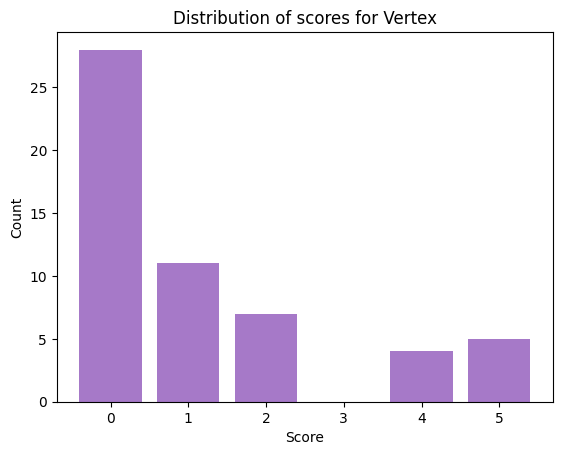

In [34]:
vertex_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in vertex_run.run_data])
category_counts = vertex_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for Vertex')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

### OpenAI Rag Assistant

#### Setup

In [39]:
def get_openai_rag_response(benchmarkItem: BenchmarkItem, assistant):
    prompt = benchmarkItem.question    
    thread = client.beta.threads.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )
    max_tries = 180
    try:
        while True:
            if max_tries == 0:
                client.beta.threads.delete(thread.id)
                raise Exception("Max tries exceeded")
            messages = client.beta.threads.messages.list(
                thread_id=thread.id,
            )
            response_message = messages.data[0].content[0].text.value
            if response_message != prompt and response_message.strip():
                annotations = messages.data[0].content[0].text.annotations
                quotes = [x.file_citation.quote for x in annotations if x.file_citation]
                client.beta.threads.delete(thread.id)
                return (response_message, quotes)
            time.sleep(1)
            max_tries -= 1
    except Exception as e:
        print(e)
        client.beta.threads.delete(thread.id)
        raise e
        
def upload_combined_essay():
    file_ids=[]
    with open('combined_6_essays.txt', 'rb') as essay_file:
        file = client.files.create(
            file=essay_file,
            purpose='assistants'
        )   
        file_ids.append(file.id)
    return file_ids

def create_assistant(file_ids):
    return client.beta.assistants.create(
        name=f"OpenAI Rag Test {len(file_ids)} Files",
        instructions=(
            "You are a chatbot that answers questions about Paul Graham's essays. "
            "Use your knowledge base to best respond to questions. "
            "NO MATTER WHAT, DO NOT PULL INFORMATION FROM EXTERNAL KNOWLEDGE. ONLY USE YOUR OWN KNOWLEDGE BASE."
        ),
        model="gpt-4-1106-preview",
        tools=[{"type": "retrieval"}],
        file_ids=file_ids
    )

def setup_assistant():
    file_ids = upload_combined_essay()    
    return create_assistant(file_ids)

#### Testing

In [40]:
client = OpenAI()
assistant = setup_assistant()

In [41]:
benchmark_item = BenchmarkItem(
    question="What is the general topic of the essay?",
    answer=""
)

print(get_openai_rag_response(benchmark_item, assistant)[0])

The general topic of the essay "Five Founders" from April 2009 is about the most interesting and influential startup founders of the last 30 years, according to Paul Graham. He discusses the five founders who have influenced him the most, and whom he often references when talking to companies funded by Y Combinator. These founders are Steve Jobs, TJ Rodgers, Larry & Sergey (treated as one person in the context of Google), Paul Buchheit, and Sam Altman【7†source】.


##### Run through all the questions

In [ ]:
with ThreadPoolExecutor(max_workers=10) as executor:
    raw_openai_responses = list(tqdm(executor.map(lambda x: get_openai_rag_response(x,assistant), benchmark.items), total=len(benchmark.items)))

  9%|███████████▎                                                                                                                 | 5/55 [00:41<05:08,  6.18s/it]

Max tries exceeded


In [ ]:
openai_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_openai_responses, benchmark.items)
]

In [ ]:
scorer = ValidateScorer([AnswerSimilarityMetric()])
openai_run = scorer.score_run(openai_responses)

In [ ]:
openai_run_df = run_to_dataframe(openai_run)
openai_run_df.to_csv("openai_run.csv", index=False)

In [ ]:
openai_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in openai_run.run_data])
category_counts = openai_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for OpenAI')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

combined_scores = pd.DataFrame({
    "OpenAI": list(openai_run_df["answer_similarity"]),
    "Vertex": list(vertex_run_df["answer_similarity"])
})

# Position of bars on x-axis
ind = np.arange(6)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3

openai_counts = combined_scores["OpenAI"].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(openai_counts.index, openai_counts.values, width, label="OpenAI", color="#5EA7EC")

vertex_counts = combined_scores["Vertex"].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(vertex_counts.index + width, vertex_counts.values, width, label="Vertex", color="#A679C8")

plt.title('Distribution of scores for OpenAI & Vertex')
plt.xlabel('Answer Similarity Score')
plt.ylabel('Count')

# Remove all scores except whole numbers
plt.xticks(ind + width / 2, range(0, 6, 1))

plt.legend(loc='best')

# Rounding the descriptive statistics to 3 significant figures
statistics_df = combined_scores.describe()
# Change 50% to 50% (median)
statistics_df = statistics_df.rename(index={'50%': 'median'})
rounded_statistics_df = statistics_df.round(3)

# Transposing the descriptive statistics table for horizontal display
rounded_statistics_df = rounded_statistics_df.T

# Adding the table below the histogram
table = plt.table(cellText=rounded_statistics_df.values,
                  colWidths=[0.1] * len(rounded_statistics_df.columns),
                  rowLabels=rounded_statistics_df.index,
                  colLabels=rounded_statistics_df.columns,
                  cellLoc = 'center', rowLoc = 'center',
                  loc='bottom', bbox=[0.0, -0.5, 1.0, 0.3])

plt.subplots_adjust(left=0.2, bottom=0.3)
plt.savefig("openai_v_vertex.png", facecolor='white', bbox_inches='tight')

plt.show()